ANOMALY DETECTION

In [20]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest, ks_2samp, pearsonr
import seaborn as sns
import warnings
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import random

Importiamo il dataset

In [21]:
mat = scipy.io.loadmat('EWS.mat')
names = list(mat.keys())[3:-2]
y = mat["Y"]
y_cat = np.zeros_like(y, dtype = int)
y_cat[y[:,0]==1.0,0] = 1
col = []
times = np.arange(y.shape[0])
for ipsilon in y:
    if ipsilon == 1.0:
        col.append("red")
    else:
        col.append("blue")
d = {}
for i, name in enumerate(names):
    if name != "None":
        d[name] = mat[names[i]]

In [22]:
Indices_Currencies = ["XAUBGNL", "BDIY", "CRY", "Cl1", "DXY", "EMUSTRUU", "GBP", "JPY", "LF94TRUU", "LF98TRUU", "LG30TRUU", "LMBITR", "LP01TREU", "LUACTRUU", "LUMSTRUU", "MXBR", "MXCN", "MXEU", "MXIN", "MXJP", "MXRU", "MXUS", "VIX"]

InterestRates = ["EONIA", "GTDEM10Y", "GTDEM2Y", "GTDEM30Y", "GTGBP20Y", "GTGBP2Y", "GTGBP30Y", "GTITL10YR", "GTITL2YR", "GTITL30YR", "GTJPY10YR", "GTJPY2YR", "GTJPY30YR", "US0001M", "USGG3M", "USGG2YR", "GT10", "USGG30YR"]

response_cat = y_cat[1:, 0]
response = y[1:, 0]

Assicuriamo la stazionarietà

In [23]:
d_stationary = {}
for feature_name in list(d.keys()):
    if feature_name in Indices_Currencies:
        temp = np.log(d[feature_name])
        d_stationary[feature_name] = temp[1:] - temp[:-1]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
        # d_stationary[feature_name] = np.log(d[feature_name][1:] / d[feature_name][1:])
    elif feature_name == "ECSURPUS":
        d_stationary[feature_name] = d[feature_name][1:]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
    elif feature_name in InterestRates:
        d_stationary[feature_name] = d[feature_name][1:] - d[feature_name][:-1]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)

Tramite un K-S test eliminiamo le variabili con una differenza di media non significativa tra i periodi di rischio o meno

Names of features with high p-value: [['GTITL10YR']
 ['GTITL30YR']
 ['GTJPY2YR']
 ['GTJPY30YR']
 ['JPY']
 ['LF94TRUU']
 ['LUACTRUU']
 ['XAUBGNL']]


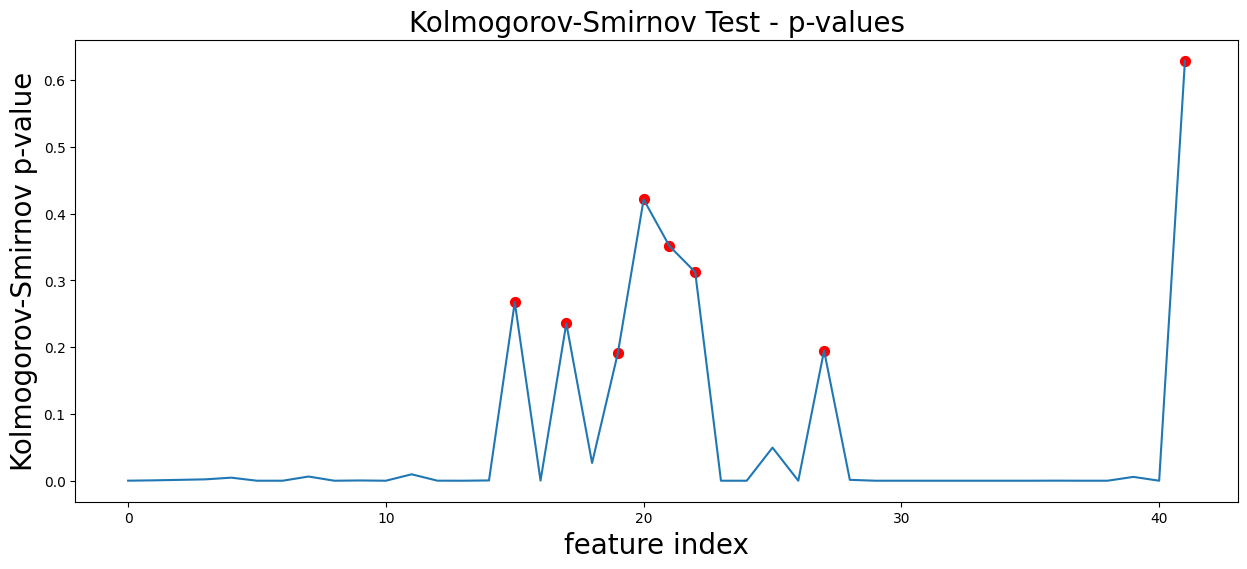

In [24]:
ks_pvalues = {}
for feature_name in list(d_stationary.keys()):
    datum = d_stationary[feature_name]
    # list(np.argwhere(y_cat[:,0] == 0).reshape(-1,))
    datum_0 = datum[np.argwhere(y_cat[1:,0] == 0)].reshape(-1,)
    datum_1 = datum[np.argwhere(y_cat[1:,0] == 1)].reshape(-1,)
    temp = ks_2samp(datum_0, datum_1)
    ks_pvalues[feature_name] = temp[1]


plt.figure(figsize = (15, 6))
names_array = np.array(list(ks_pvalues.keys()))
ks_pvalues = np.array(list((ks_pvalues.values())))
plt.plot(ks_pvalues)
high_pval = np.argwhere(np.array(ks_pvalues) > 0.05)
plt.scatter(high_pval.ravel(), ks_pvalues[high_pval.ravel()], c = "red", s = 50)
plt.ylabel("Kolmogorov-Smirnov p-value", fontsize=20)
plt.xlabel("feature index", fontsize=20)
plt.title("Kolmogorov-Smirnov Test - p-values", fontsize=20)
# plt.show()
# plt.savefig('plots' + os.sep + 'ks_pvalues')

print("Names of features with high p-value:", names_array[high_pval])

Eliminiamo altre variabili tramite uno studio di correlazione

<AxesSubplot:>

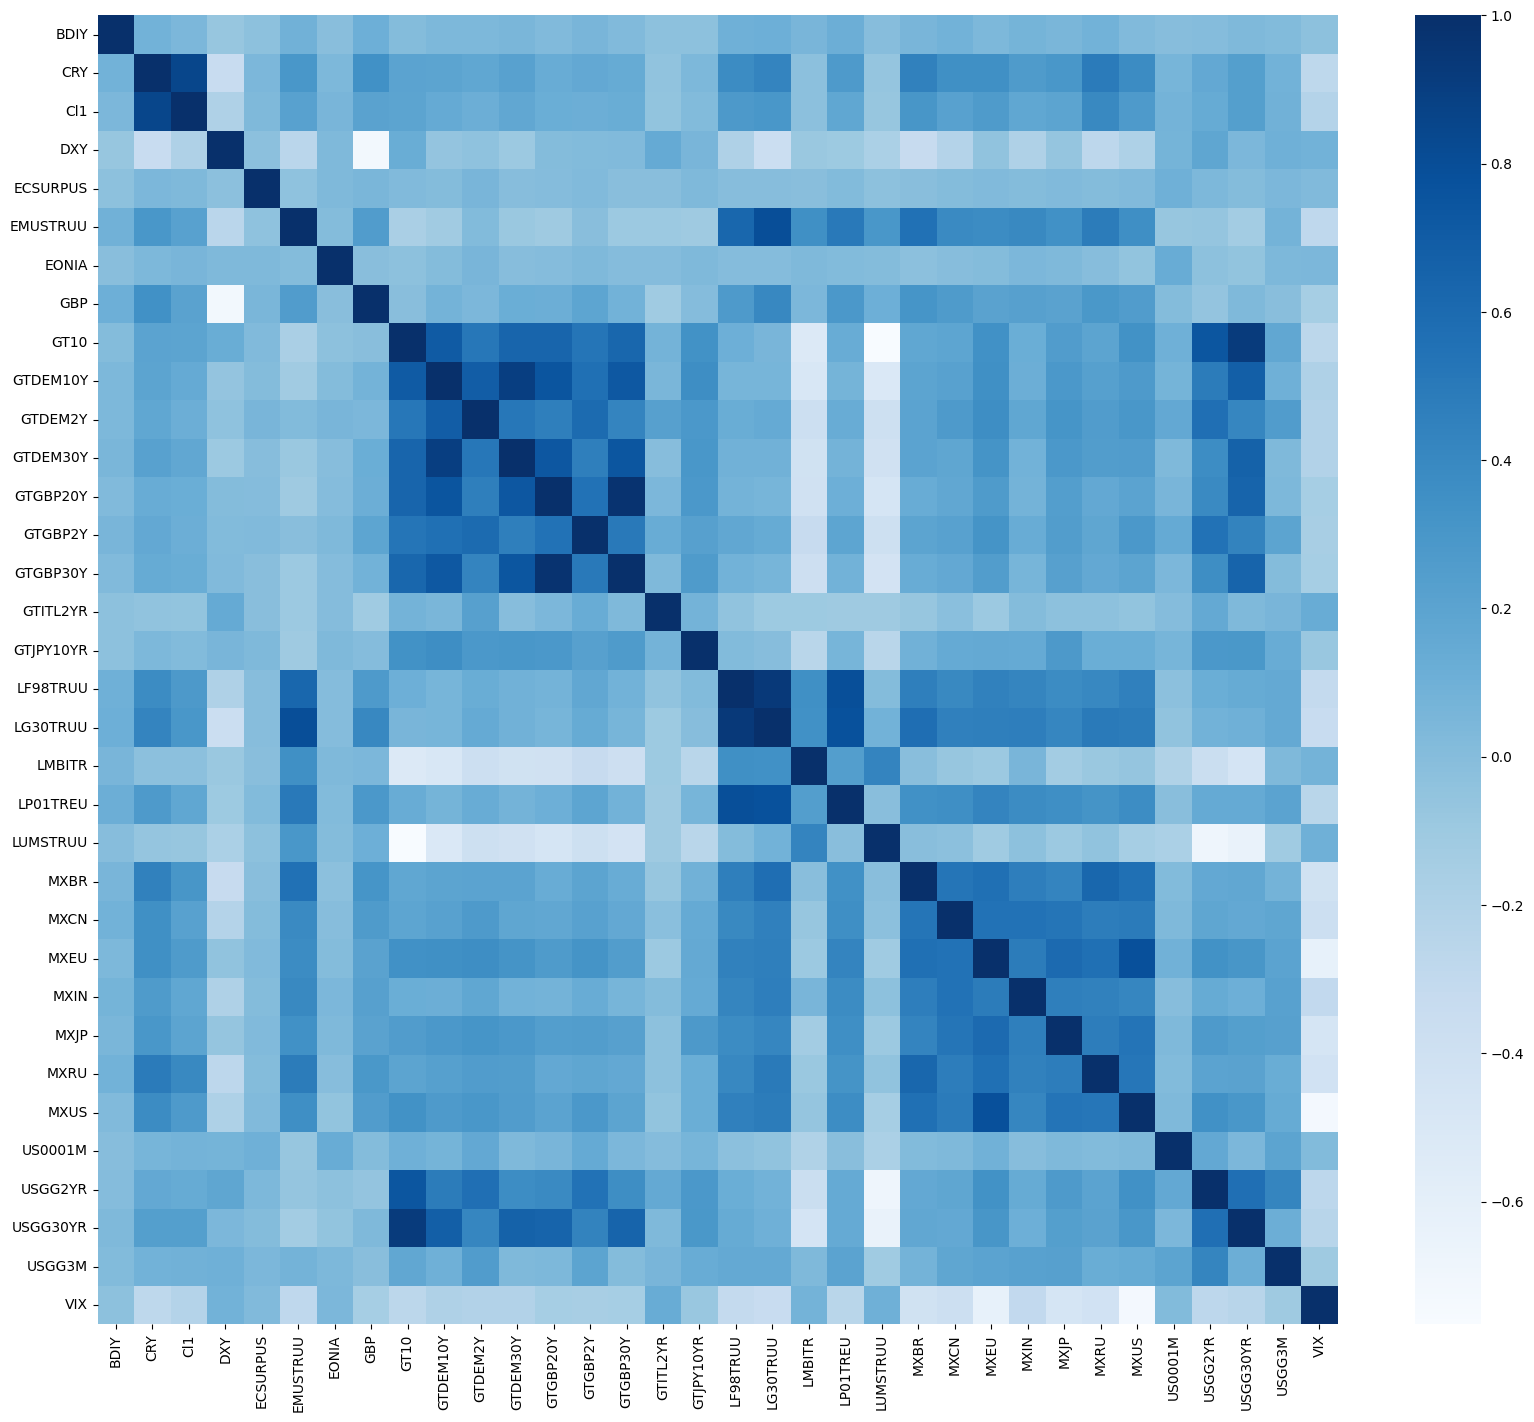

In [25]:
df = pd.DataFrame(d_stationary)
df_1 = df.drop(df.columns[list(high_pval[:,0])], axis=1)
corr_matrix = df_1.corr()
fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")

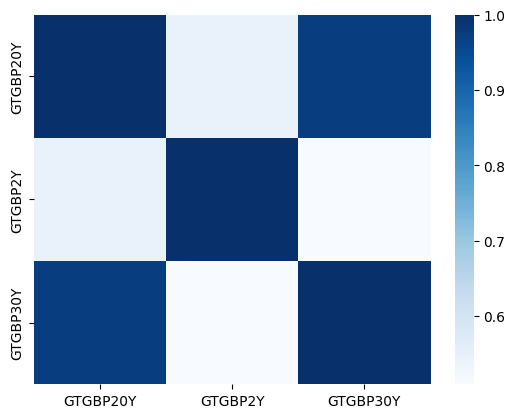

In [26]:
british_bonds = ['GTGBP20Y', 'GTGBP2Y','GTGBP30Y']
corr_matrix = df_1.loc[:,british_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs
df_1 = df_1.drop(['GTGBP20Y','GTGBP30Y'], axis=1)

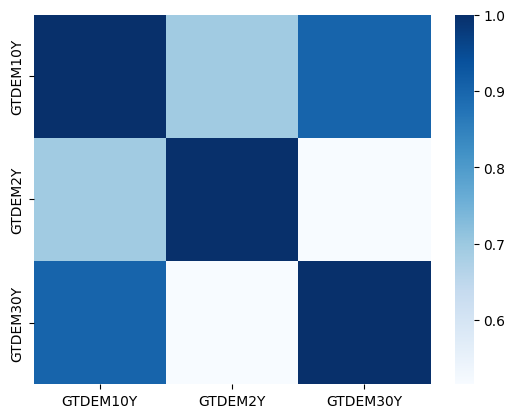

In [27]:
german_bonds = ['GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y']
corr_matrix = df_1.loc[:,german_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs
df_1 = df_1.drop(['GTDEM10Y','GTDEM30Y'], axis=1)

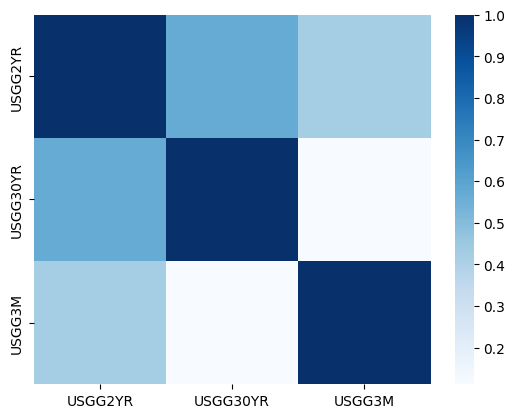

In [28]:
us_bonds = ['USGG2YR', 'USGG30YR', 'USGG3M']
corr_matrix = df_1.loc[:,us_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs and 3 months
df_1 = df_1.drop(['USGG30YR'], axis=1)

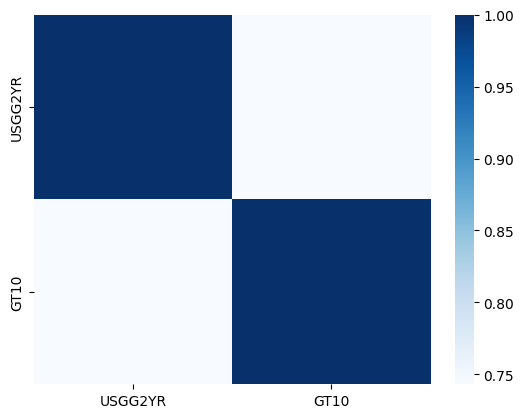

In [29]:
us_bonds = ['USGG2YR', 'GT10']
corr_matrix = df_1.loc[:,us_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs
df_1 = df_1.drop(['GT10'], axis=1)
df_1 = df_1.drop(['Cl1', "LG30TRUU", "LF98TRUU", "LP01TREU", "LMBITR"], axis=1)

<AxesSubplot:>

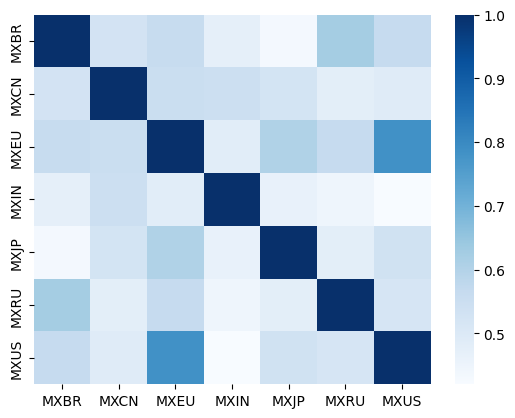

In [30]:
market_indices = ["MXBR", "MXCN", "MXEU", "MXIN", "MXJP", "MXRU", "MXUS"]
corr_matrix = df_1.loc[:,market_indices].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# we keep them all

<AxesSubplot:>

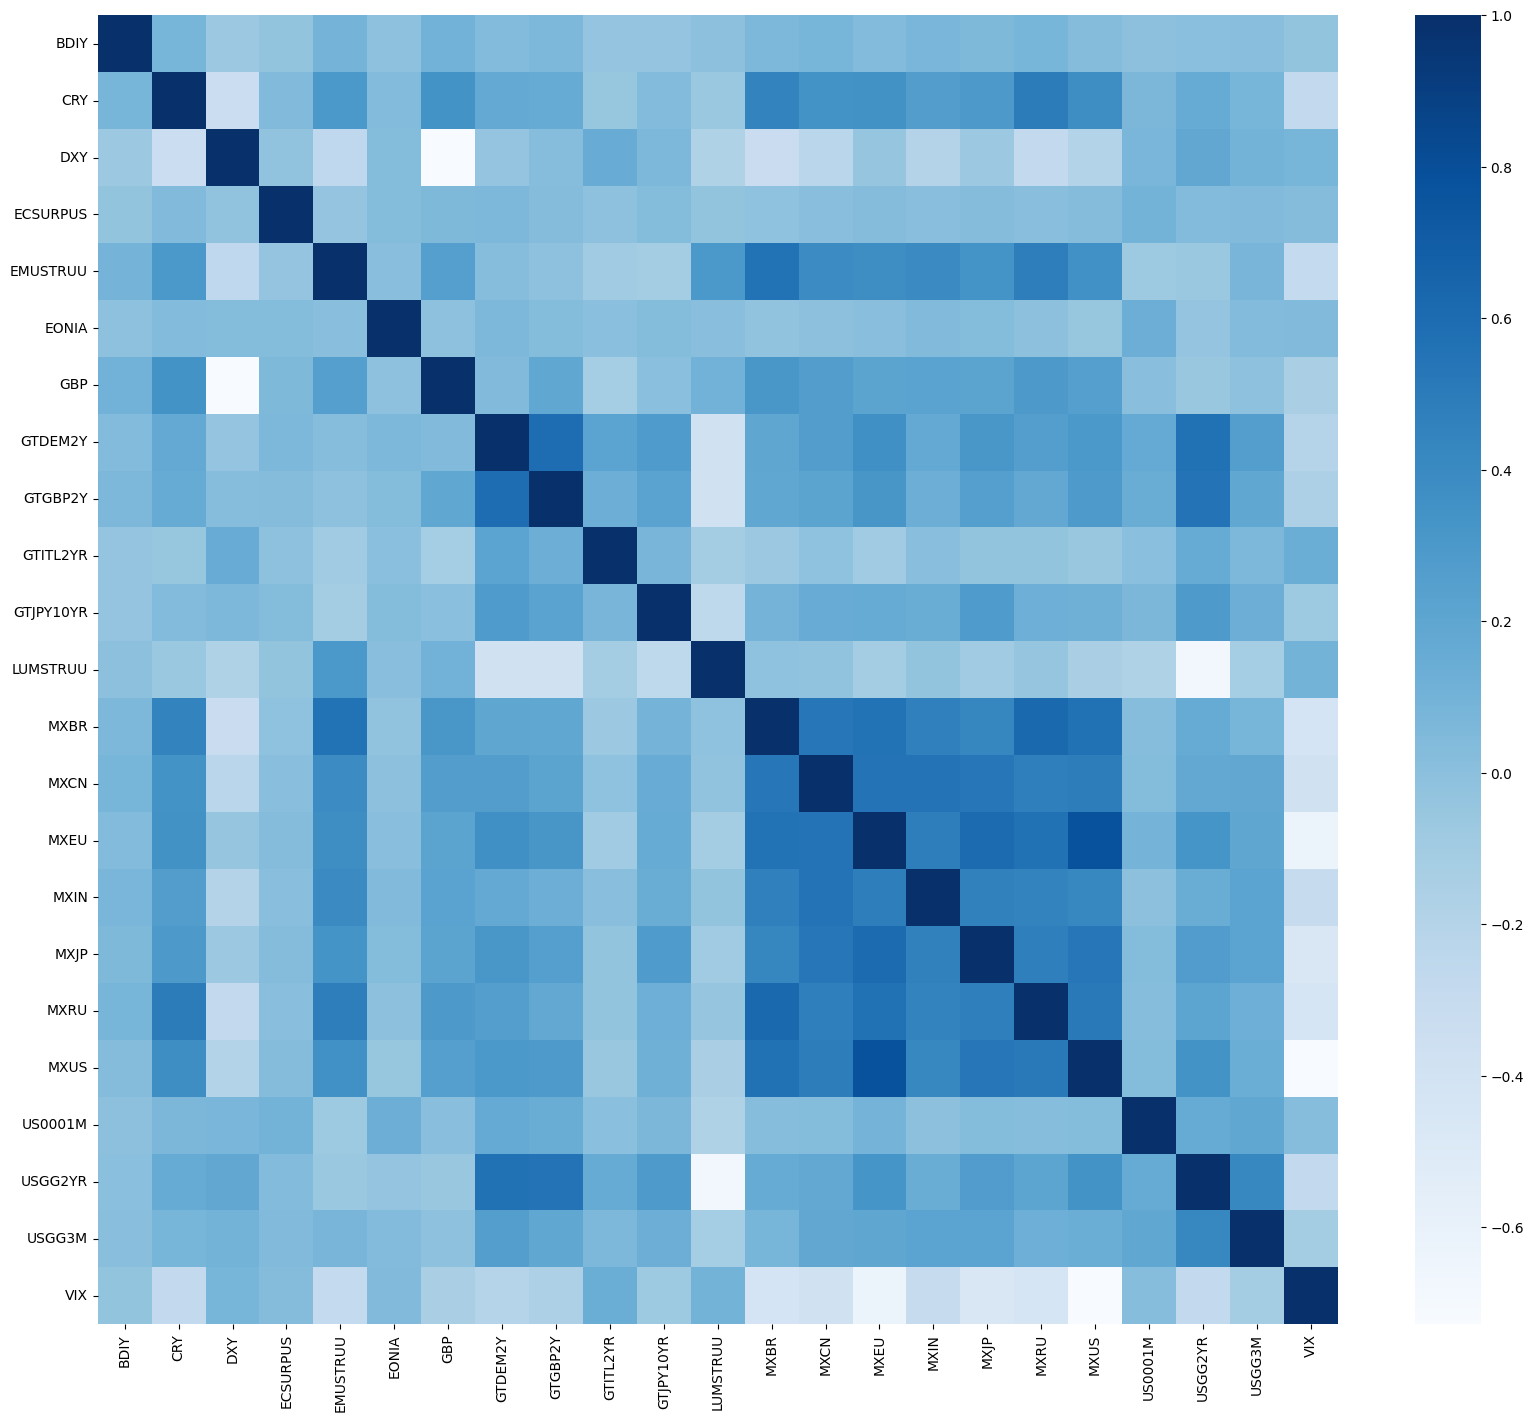

In [31]:
corr_matrix = df_1.corr()
fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")

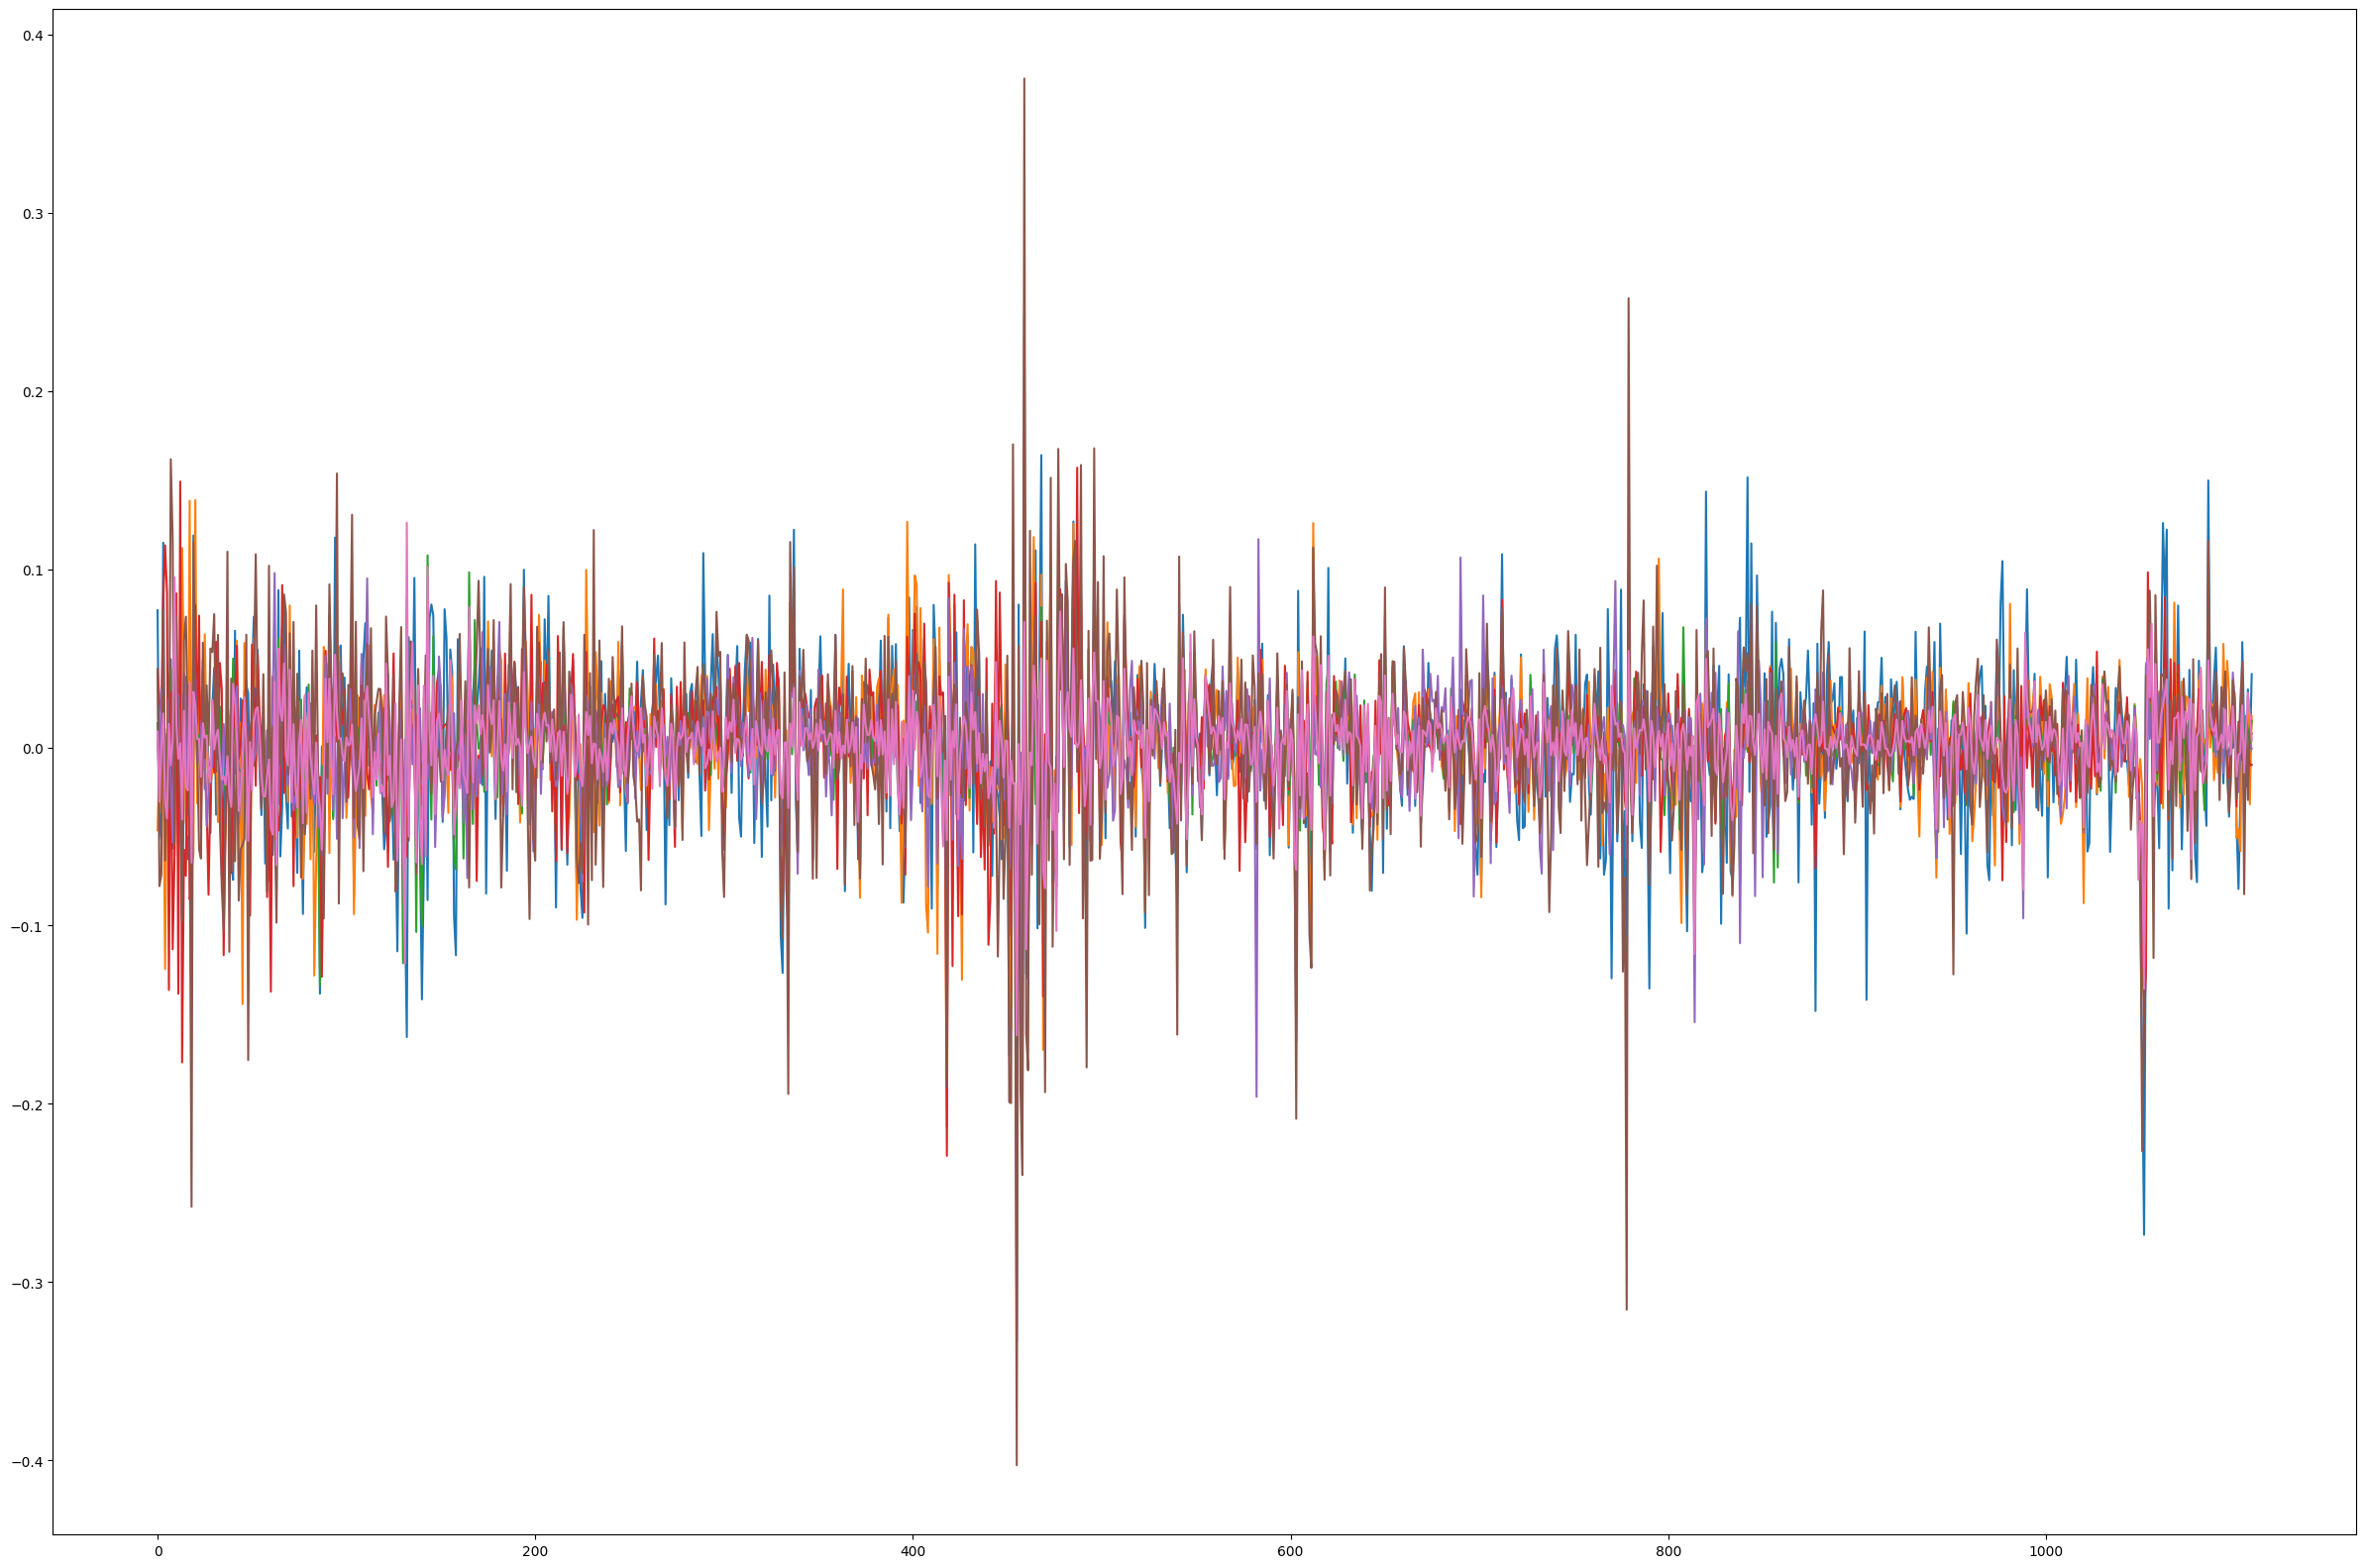

In [32]:
plt.figure(figsize = (30,20))
plt.plot(df_1.loc[:,market_indices])
plt.show()

dai due grafici soprastanti si vede che ora abbiamo dati significativi e stazionari

Isolation Forest (sbilanciatissimissima)

In [33]:
test_size = int(0.2*df_1.values.shape[0])
exclude = np.random.choice(df_1.values.shape[0], test_size, replace=False)
mask = np.ones(df_1.values.shape[0], bool)
mask[exclude] = False
y_cat_new = y_cat[1:,0]
X_train = pd.DataFrame(d_stationary).values[mask == True]
y_train = y_cat_new[mask == True]
X_test = pd.DataFrame(d_stationary).values[mask == False]
y_test = y_cat_new[mask == False]


clf = IsolationForest(contamination=0.2, n_estimators = 1000)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_test[y_pred_test == -1] = 1
C_test = confusion_matrix(y_test,y_pred_test)
print("------------------------")
print("Performance on TEST SET:")
print("------------------------")
print("tn fn \nfp tp")
print(C_test)
print("anomalies in the test set:",sum(y_test))
print("normal points in the test set:",y_test.shape[0]-sum(y_test))
print("anomalies predicted (test set):",sum(y_pred_test))
print("normal points (test set):",y_pred_test.shape[0]-sum(y_pred_test))
recall = C_test[1,1]/(C_test[1,1] + C_test[0,1])
precision = C_test[1,1]/(C_test[1,1] + C_test[1,0])
print("recall:", recall)
print("precision:", precision)

y_pred_train[y_pred_train == -1] = 1
C_train = confusion_matrix(y_train,y_pred_train)
print("-------------------------")
print("Performance on TRAIN SET:")
print("-------------------------")
print("tn fn \nfp tp")
print(C_train)
print("anomalies in the train set:",sum(y_train))
print("normal points in the train set:",y_train.shape[0]-sum(y_train))
print("anomalies predicted (train set):",sum(y_pred_train))
print("normal points (train set):",y_pred_train.shape[0]-sum(y_pred_train))
recall = C_train[1,1]/(C_train[1,1] + C_train[0,1])
precision = C_train[1,1]/(C_train[1,1] + C_train[1,0])
print("recall:", recall)
print("precision:", precision)

------------------------
Performance on TEST SET:
------------------------
tn fn 
fp tp
[[  0 181]
 [  0  41]]
anomalies in the test set: 41
normal points in the test set: 181
anomalies predicted (test set): 222
normal points (test set): 0
recall: 0.18468468468468469
precision: 1.0
-------------------------
Performance on TRAIN SET:
-------------------------
tn fn 
fp tp
[[  0 692]
 [  0 196]]
anomalies in the train set: 196
normal points in the train set: 692
anomalies predicted (train set): 888
normal points (train set): 0
recall: 0.22072072072072071
precision: 1.0


Proviamo con una tecnica di Oversampling

In [34]:
df_original = df_1.copy()
X = df_original.values
y = y_cat[1:,:].reshape(-1,1)
original_number_of_anomalies = sum(y.ravel())

In [36]:
from imblearn.over_sampling import RandomOverSampler

nros = RandomOverSampler()
X_nros, y_nros = nros.fit_resample(X, y)
new_number_of_anomalies = sum(y_nros.ravel())
delta_numer_of_anomalies = new_number_of_anomalies-original_number_of_anomalies
print("Number of new anomalies added:", delta_numer_of_anomalies)
print("NROS has added", 100*delta_numer_of_anomalies/original_number_of_anomalies, "% more anomalies.")
print("New ratio of 0-1:", {0: np.sum(y_nros==0)/y_nros.shape[0], 1: np.sum(y_nros==1)/y_nros.shape[0]})

Number of new anomalies added: 636
NROS has added 268.3544303797468 % more anomalies.
New ratio of 0-1: {0: 0.5, 1: 0.5}


In [37]:
def choose_k(X_val, y_val):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_optimizing_metric = 0
    best_params = np.zeros((2,))
    best_k = -1
    for k in range(2, X_val.shape[0], 1):
      model_k = KNeighborsClassifier(n_neighbors=k)
      model_k.fit(X_val,y_val)
      y_hat_val = model_k.predict(X_val) 
      C_val = confusion_matrix(y_val,y_hat_val)
      recall = C_val[1,1]/(C_val[1,1] + C_val[0,1])
      precision = C_val[1,1]/(C_val[1,1] + C_val[1,0])
      # optimizing_metric = precision * recall / (precision + recall)
      # optimizing_metric = precision
      # optimizing_metric = recall
      # optimizing_metric = 0.95 * precision + 0.05 * recall
      optimizing_metric = 0.95 * precision + 0.05 * recall
      if optimizing_metric > best_optimizing_metric:
        best_optimizing_metric = optimizing_metric
        best_params[0] = recall
        best_params[1] = precision
        best_k = k
  return (best_k, best_params)

def random_permutation(dataset, percentage):
  final_size = int(np.floor(percentage*dataset.shape[0]))
  n = dataset.shape[0]
  idxPermutation = np.array(random.sample([index for index in range(n)], final_size)).ravel()
  idxExclude = [index_to_exlude for index_to_exlude in range(n) if index_to_exlude not in list(idxPermutation)]
  idxExclude = np.array(idxExclude).ravel()
  return idxPermutation, idxExclude

In [39]:
X_list = [X_nros]
y_list = [y_nros]
model_names = ["Naive random oversampling"]
confusion_matrices = []
models = []

for i, X_augmented in enumerate(X_list):

  print("------------------------------------------")
  print("WORKING WITH", model_names[i])
  print("------------------------------------------")

  y_augmented = y_list[i]
  test_size = int(0.2*X_augmented.shape[0])

  # create test set
  exclude = np.random.choice(X_augmented.shape[0], test_size, replace=False)
  mask = np.ones(X_augmented.shape[0], bool)
  mask[exclude] = False
  X_train_tot = X_augmented[mask == True]
  y_train_tot = y_augmented[mask == True]
  X_test = X_augmented[mask == False]
  y_test = y_augmented[mask == False]

  # create validation set
  val_size = int(0.3*X_train_tot.shape[0])
  exclude = np.random.choice(X_train_tot.shape[0], val_size, replace=False)
  mask = np.ones(X_train_tot.shape[0], bool)
  mask[exclude] = False
  X_train = X_train_tot[mask == True]
  y_train = y_train_tot[mask == True]
  X_val = X_train_tot[mask == False]
  y_val = y_train_tot[mask == False]
  

  print("train set shape and ratio of 0-1", X_train.shape, "-->", (np.sum(y_train==0)/y_train.shape[0], np.sum(y_train==1)/y_train.shape[0]))
  print("test set shape and ratio of 0-1", X_test.shape, "-->", (np.sum(y_test==0)/y_test.shape[0], np.sum(y_test==1)/y_test.shape[0]))
  print("validation set shape and ratio of 0-1", X_val.shape, "-->", (np.sum(y_val==0)/y_val.shape[0], np.sum(y_val==1)/y_val.shape[0]))

  # tune k using validation set
  best_k, best_params = choose_k(X_val, y_val)
  print("best k in CV:", best_k)
  print("best recall in CV:", best_params[0])
  print("best precision in CV:", best_params[1])

  # model = KNeighborsClassifier(n_neighbors=best_k)
  model = KNeighborsClassifier(n_neighbors=5)
  models.append(model)
  model.fit(X_train,y_train)
  predicted = model.predict(X_test)
  C = confusion_matrix(y_test,predicted)
  confusion_matrices.append(C)
  print("tn fn, \nfp tp")
  print(C)
  recall = C[1,1]/(C[1,1] + C[0,1])
  precision = C[1,1]/(C[1,1] + C[1,0])
  print("test set recall:", recall)
  print("test set precision:", precision)

------------------------------------------
WORKING WITH Naive random oversampling
------------------------------------------
train set shape and ratio of 0-1 (978, 23) --> (0.49897750511247446, 0.5010224948875256)
test set shape and ratio of 0-1 (349, 23) --> (0.46131805157593125, 0.5386819484240688)
validation set shape and ratio of 0-1 (419, 23) --> (0.5346062052505967, 0.46539379474940334)
best k in CV: 3
best recall in CV: 0.8631578947368421
best precision in CV: 0.841025641025641
tn fn, 
fp tp
[[115  46]
 [ 59 129]]
test set recall: 0.7371428571428571
test set precision: 0.6861702127659575
